# Udacity Data Analyst Nanodegree
### Project 2 - Investigate a dataset: Titanic Dataset Analysis

## Part 1: Abstract

__The main question this project seeks to answer is:__ Is passenger class, sex, or age associated with survival rates for the Titanic disaster?

Python and Pandas were used to analyze a set of passenger data from the Titanic to see if class, sex, or age were factors that were associated with survival rates for the Titanic. This project will start by first importing and cleaning the data, then will move to an exploratory phase to test for associations between the listed factors and survival rates, then will finish by presenting conclusions about any associations that have been found and doing a brief multivariate exploration of the mentioned factors.

## Part 2: Data formatting and cleaning

### 2.1 Data import and initial checks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data from the supplied CSV
titanic = pd.read_csv('./titanic_data.csv')

In [3]:
# Check the first few rows of the data to get a feel for what values the columns can contain
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


### 2.2 Imputation of missing values

In [4]:
# Check to see if there are any missing values in the data
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Of the columns of interest only Age has missing values and is missing 19.9% of it's values. The missing values are imputed with mean values based on passenger class and sex.

In [5]:
ages_before_imputation = titanic['Age'].copy(deep=True)

In [6]:
age_estimates = titanic[['Pclass', 'Sex', 'Age']].groupby(['Pclass', 'Sex']).mean()
age_estimates

Age
Pclass Sex              
1      female  34.611765
       male    41.281386
2      female  28.722973
       male    30.740707
3      female  21.750000
       male    26.507589

In [7]:
def impute_age(passenger):
    titanic.loc[passenger['PassengerId'] - 1 , 'Age'] = age_estimates.loc[passenger['Pclass'], passenger['Sex']][0]
        
titanic[titanic['Age'].isnull()].apply(impute_age, axis=1);

The graph below show the impact of the age imputation on the distribution of age values. While imputing ages based off of the means from the corresponding sex and class groups does give us a better fit to the original distribution than imputing only the overall sample mean, it still has the effect of biasing the variance downwards and increasing kurtosis by concentrating more values towards the center of the distribution. This will have the effect that any computed correlations with this variable will be attenuated to some degree.

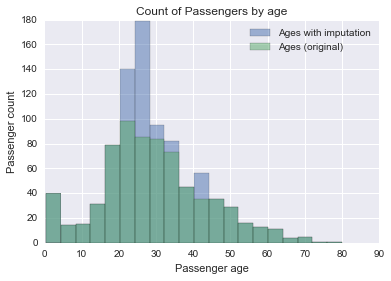

In [8]:
plt.hist(titanic['Age'], bins=20, alpha=0.5, label='Ages with imputation')
plt.hist(ages_before_imputation.dropna(), bins=20, alpha=0.5, label='Ages (original)')
plt.title('Count of Passengers by age')
plt.xlabel('Passenger age')
plt.ylabel('Passenger count')
plt.legend()

### 2.3 Value range checks for remaining columns
Now that the missing values have been dealt with, the remaining columns are checked to make sure the ranges of the values they contain are reasonable for their type and meaning (e.g. the sex values only contain the period appropriate male/female gender binary, the survived column only contains 0 or 1, etc.) From the checks shown below, no further data cleaning was found to be warranted.

In [9]:
# Check that the 'Passenger Id' is always present and one greater than the row index
len(titanic[titanic['PassengerId'] == (titanic.index + 1)]) == len(titanic)

True

In [10]:
# Check that 'Survived' is always '1' or '0'
titanic['Survived'].unique()

array([0, 1])

In [11]:
# Check that 'Pclass' is always '1', '2', or '3'
titanic['Pclass'].unique()

array([3, 1, 2])

In [12]:
# Check that 'Sex' is always 'male' or 'female'
titanic['Sex'].unique()

array(['male', 'female'], dtype=object)

In [13]:
# Check that 'Age' has a sensible range ranges (0-100 years)
[titanic['Age'].min(), titanic['Age'].max()]

[0.42, 80.0]

### 2.4 Assign numerical values to categorical data

In order to facilitate numerical analysis, it would be helpful to have categorical data also be represented numerically. Specifically, to allow computation on gender ratios a 'Female' boolean column will be added which allows pandas to do numeric computation (by treating True as 1 and False as 0).

In [14]:
titanic["Female"] = (titanic["Sex"] == "female")

## Part 3: Data exploration

### 3.1 Basic descriptive statistics

The table below is a high level overview used to help get acquainted with the data. It presents some measures of central tendency and variability to help guide data exploration.

In [15]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Female
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891
mean,446.000000,0.383838,2.308642,29.318643,0.523008,0.381594,32.204208,0.352413
std,257.353842,0.486592,0.836071,13.281103,1.102743,0.806057,49.693429,0.4779901
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,False
25%,223.500000,0.000000,2.000000,21.750000,0.000000,0.000000,7.910400,0
50%,446.000000,0.000000,3.000000,26.507589,0.000000,0.000000,14.454200,0
75%,668.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000,1
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,True


### 3.2 Testing for class, sex, or age association with survival rates

From the available passenger data the class, age, and sex data will be investigated to see if they are associated with survival rates. First, each variable will undergo univariate analysis to check for anomalies, outliers, highly skewed distributions, or anything that could affect the integrity of our tests or models. Then, the variable vs survival rate will be graphed for visual inspection followed by a suitable statistical test to check for association or independence between the variable and survival rates. Lastly, there will be an attempt to quantify any association that is found.

#### 3.2.1 Passenger Class

__Univariate analysis:__ All the data conforms to the restrictions from section 2.3 and there are no anomalies present. It should be noted that there is over twice the amount of data for passenger class three than there is for classes one or two, but all classes have more than enough data points for the statistical methods chosen here.

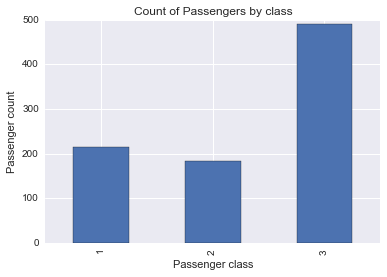

In [16]:
titanic['Pclass'].value_counts(sort=False).plot(kind='bar')
plt.title('Count of Passengers by class')
plt.xlabel('Passenger class')
plt.ylabel('Passenger count')

__Graphing the passenger class vs. suruvial rates:__ The survival rate for each passenger class is graphed below. From it, a clear association between the variables is visible.

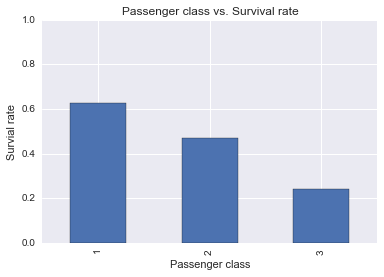

In [17]:
titanic.groupby('Pclass')['Survived'].mean().plot(kind='bar', ylim=[0,1])
plt.title('Passenger class vs. Survival rate')
plt.xlabel('Passenger class')
plt.ylabel('Survial rate')

__Independence testing:__ A Chi-Squared test for independence is preformed below with a criterion level of $\alpha = 0.05$ required to reject $H_0$. The test shows a Chi-Squared statistic of 102.89 with a p-value less than 0.0001, so the null hypothesis can be rejected.

$H_0:$ The passenger class and survival rate variables are independent.

$H_A:$ The passenger class and survival rate variables are dependent.

In [18]:
class_crosstab = pd.crosstab(titanic['Survived'], titanic['Pclass'])
class_crosstab

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [19]:
chi_squared, p_value, _, _ = stats.chi2_contingency(class_crosstab)
[chi_squared, p_value]

[102.88898875696056, 4.5492517112987927e-23]

__Quantifying the association:__ Now that the association between passenger class and survival has been found to be statistically significant, it is quantified using Spearman's rank correlation coefficient (the more common Pearson's r coefficient is not appropriate in this case because the class data is both ordinal and non-interval). A Spearman's rho correlation of -0.340 was obtained which shows a moderate correlation in the negative direction, i.e. the higher numerical value of your class the lower the survival rate.

In [20]:
stats.spearmanr(titanic['Pclass'], titanic['Survived'])[0] # Spearman's rho

-0.33966793665005246

#### 3.2.2 Passenger Age

__Univariate analysis:__ All the data conforms to the restrictions from section 2.3. The data does have some degree of elevated kurtosis (0.705) due to the mean imputation from section 2.2, is skewed a little to the right, and has a bump in then number children below 10 years of age. However, the data does remain close enough to the normal distribution to use the statistical methods shown below.

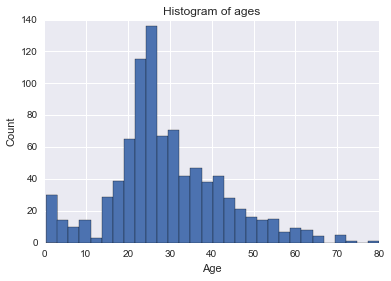

In [21]:
titanic['Age'].plot(kind='hist', bins=30)
plt.title('Histogram of ages')
plt.xlabel('Age')
plt.ylabel('Count')

In [22]:
stats.kurtosis(titanic['Age'])

0.7044911703192969

__Graphing age vs. suruvial rates:__ The survival rate for each passenger age group is graphed below. From it, no clear association between age and survival rate can be seen. It should be noted that there was only a single passenger in the last bin, so the 100% survival rate is an anomaly due to a low sample count in that bin. Also, children below 7 years of age had a bump in survival rate, but that does not generalize to a broad association across the other ages.

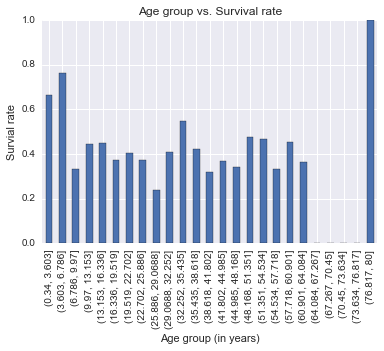

In [23]:
titanic['Age_bin'] = pd.cut(titanic['Age'], bins=25)
titanic.groupby('Age_bin')['Survived'].mean().plot(kind='bar', ylim=[0,1])
plt.title('Age group vs. Survival rate')
plt.xlabel('Age group (in years)')
plt.ylabel('Survial rate')

__Independence testing:__ The age data has been separated into two groups; survived and perished. These two groups will underwent a two-tailed independent t-test for the two samples with a criterion level of $\alpha = 0.05$ required to reject $H_0$. The p-value of 0.044 failed to reject the null under the two tailed $\alpha$ level criterion so we cannot say that these two group have a statistically different mean.

$H_0: \mu_{survived} = \mu_{perished}$

$H_A: \mu_{survived} \neq \mu_{perished}$

In [24]:
survived = titanic[titanic['Survived'] == 1]['Age'].values
perished = titanic[titanic['Survived'] == 0]['Age'].values

In [25]:
stats.ttest_ind(survived, perished)

(-2.0167365616465727, 0.044023247530017753)

Below is a histogram comparing the two samples, perished and survived.

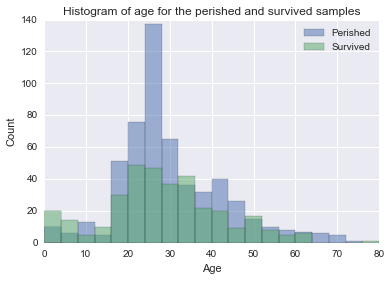

In [26]:
pyplot.hist(perished, bins=20, range=[0, 80], alpha=0.5, label='Perished')
pyplot.hist(survived, bins=20, range=[0, 80], alpha=0.5, label='Survived')
plt.title('Histogram of age for the perished and survived samples')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

__Quantifying the association:__ Since the t-test failed to show a statistically significant difference between the perished and survived samples an attempt to quantify the correlation using a Point biserial correlation should return a low number, which indeed it does (-0.0675).

In [27]:
stats.pointbiserialr(titanic['Survived'], titanic['Age'])[0] # Point biserial correlation

-0.067484975685333889

#### 3.2.3 Passenger Sex

__Univariate analysis:__ All the data conforms to the restrictions from section 2.3 and there are no anomalies present. It should be noted that there is roughly twice as many men as women, but both sexes have more than enough data points for the statistical methods chosen here.

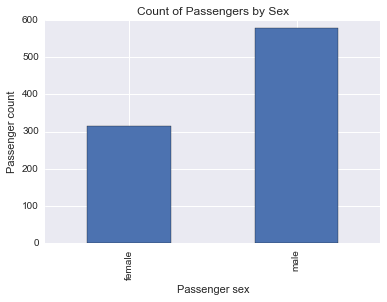

In [28]:
titanic['Sex'].value_counts(sort=False).plot(kind='bar')
plt.title('Count of Passengers by Sex')
plt.xlabel('Passenger sex')
plt.ylabel('Passenger count')

__Graphing the passenger sex vs. suruvial rates:__ The survival rate for passengers by sex is graphed below. From it, a clear association between the variables is visible.

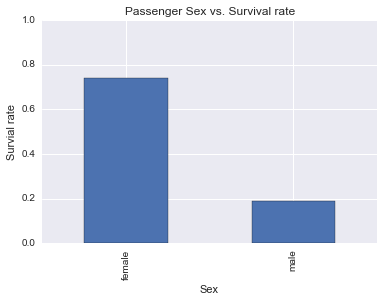

In [29]:
titanic.groupby('Sex')['Survived'].mean().plot(kind='bar', ylim=[0,1])
plt.title('Passenger Sex vs. Survival rate')
plt.xlabel('Sex')
plt.ylabel('Survial rate')

__Independence testing:__ A Chi-Squared test for independence is preformed below with a criterion level of $\alpha = 0.05$ required to reject $H_0$. The test shows a Chi-Squared statistic of 260.72 with a p-value less than 0.0001, so the null hypothesis can be rejected.

$H_0:$ The passenger sex and survival rate variables are independent.

$H_A:$ The passenger sex and survival rate variables are dependent.

In [30]:
age_crosstab = pd.crosstab(titanic['Survived'], titanic['Sex'])
age_crosstab

Sex,female,male
Survived,,
0,81,468
1,233,109


In [31]:
chi_squared, p_value, _, _ = stats.chi2_contingency(age_crosstab)
[chi_squared, p_value]

[260.71702016732104, 1.1973570627755645e-58]

__Quantifying the association:__ Now that the association between passenger sex and survival has been found to be statistically significant, it is quantified using Pearson's phi coefficient (Pearson's r for two binary variables). A Pearson's phi coefficient of 0.54 was obtained which shows a moderate association between between sex and survival rates where being female correlates to a higher survival rate.

In [32]:
stats.pearsonr(titanic['Female'], titanic['Survived'])[0] # Pearson's phi (Pearson's r for two binary variables)

0.54335138065775523

## Part 4: Conclusion

__The main question this project sought to answer is:__ Is passenger class, sex, or age associated with survival rates for the Titanic disaster? In brief, the answer is yes for class and sex, no for age.

More specifically, from the data exploration preformed in Part 3 it was found that class, and sex were correlated with survival rates while age was not. Sex had the highest correlation with survival rates with a Pearson's phi coefficient of 0.543, followed by passenger class with a Spearman's rho coefficient of 0.340. Age, when split into survived and perished samples, failed to pass an independent sample t-test at a criterion of $\alpha = 0.05$ so it failed to show a significant difference between the groups means.

It is important to note that although it is easy to draw conclusions about causations in this event due to various famous sentiments similar to 'Women and children first', this is an observation study not an experimental design so only correlations can be shown, causations cannot be inferred.

__Limitations of analysis:__ The imputation for missing age variables used the mean values from matching sex and class samples. When the means were imputed, the variability of the ages and their correlation with other variables were biased downwards. This caused the the correlation between age and survivorship to be under-reported. The increase is mean values for age also increased kurtosis which can affect the t-test assumption of normality, though in this case the kurtosis was deemed not to be extreme enough to cause violate that assumption.

__Confounding variables__: This analysis has focused on a single variables association with survival rate at a time, but it's worth keeping in mind that part of one variables correlation may be explained by another related variable. For instance, at least some of the correlation between passenger class and survival rate can be explained by the higher rate of females in the higher passenger classes (and vice versa), as shown below. Since the data set only included a handful of variables, it is also possible that there are further confounding variables that are unknown and which affect the correlations in this project.

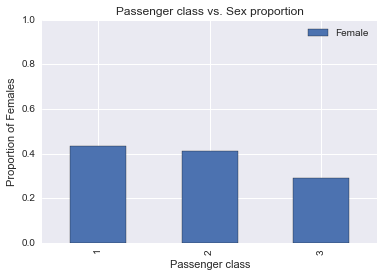

In [33]:
titanic[['Pclass', 'Female']].groupby('Pclass').mean().plot(kind='bar', ylim=[0,1])
plt.title('Passenger class vs. Sex proportion')
plt.xlabel('Passenger class')
plt.ylabel('Proportion of Females')

__Multivariate visualizations:__ A summary of the class and sex factors on survival rate are shown in the contingency table and graph below. As expected from the analysis, first class females had the highest survival rate while third class males had the lowest.

In [34]:
titanic[['Pclass','Sex','Survived']].groupby(['Pclass', 'Sex']).mean()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

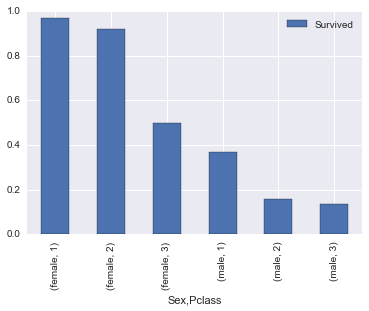

In [35]:
titanic[['Pclass','Sex','Survived']].groupby(['Sex', 'Pclass']).mean().plot(kind='bar')

The distributions of age and class, and age and sex are also interesting. It seems that the lower the numeric value of the class, the older the passenger. Also, females tend to be slightly younger than males.

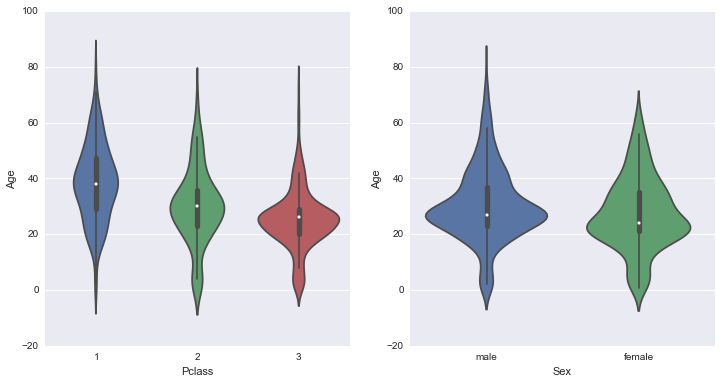

In [37]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
sns.violinplot(data = titanic, x = 'Pclass', y = 'Age', order=[1,2,3], ax=ax1)
sns.violinplot(data = titanic, x = 'Sex', y = 'Age', ax=ax2)